In [1]:
!pip install nltk wordcloud

In [2]:
#importing lobrarires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from sklearn.model_selection import train_test_split

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
from google.colab import files
uploaded = files.upload()


Saving Fake.csv to Fake (1).csv
Saving True.csv to True (1).csv


In [7]:
# Load datasets
df_fake = pd.read_csv('Fake.csv')
df_true = pd.read_csv('True.csv')

# Add labels
df_fake['label'] = 0  # Fake = 0
df_true['label'] = 1  # Real = 1

# Combine
df = pd.concat([df_fake, df_true], ignore_index=True)

# Check data
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


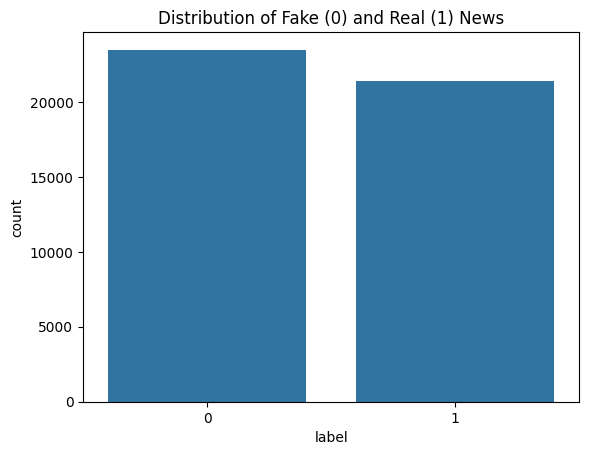

title      0
text       0
subject    0
date       0
label      0
dtype: int64


In [8]:
#eda
# Class distribution
sns.countplot(x='label', data=df)
plt.title('Distribution of Fake (0) and Real (1) News')
plt.show()

# Null values
print(df.isnull().sum())


In [9]:
#Data cleaning
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.split()
    text = [word for word in text if word not in stop_words]
    return ' '.join(text)

df['cleaned_text'] = df['text'].apply(clean_text)
df[['text', 'cleaned_text']].head()


,text,cleaned_text
0,Donald Trump just couldn t wish all Americans ...,donald trump wish americans happy new year lea...
1,House Intelligence Committee Chairman Devin Nu...,house intelligence committee chairman devin nu...
2,"On Friday, it was revealed that former Milwauk...",friday revealed former milwaukee sheriff david...
3,"On Christmas day, Donald Trump announced that ...",christmas day donald trump announced would bac...
4,Pope Francis used his annual Christmas Day mes...,pope francis used annual christmas day message...


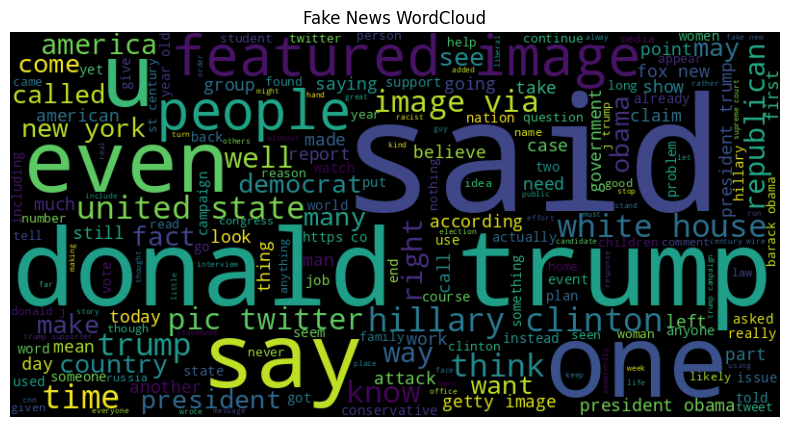

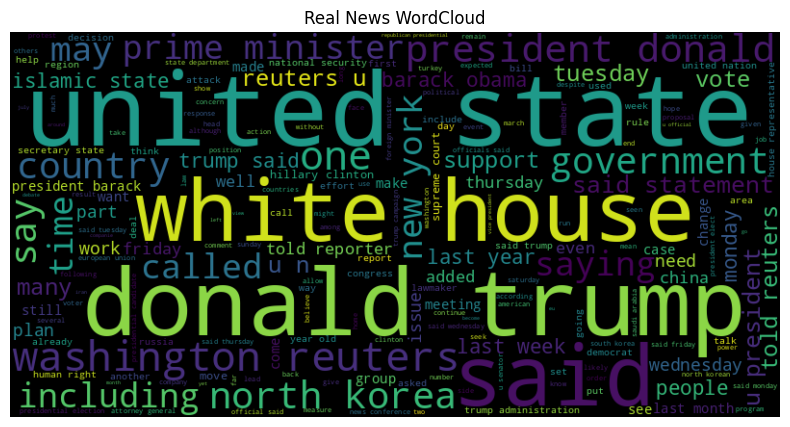

In [10]:
#Word cloud viaulaization
# Fake news word cloud
fake_text = ' '.join(df[df['label']==0]['cleaned_text'])
plt.figure(figsize=(10,5))
wc = WordCloud(width=800, height=400).generate(fake_text)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Fake News WordCloud')
plt.show()

# Real news word cloud
real_text = ' '.join(df[df['label']==1]['cleaned_text'])
plt.figure(figsize=(10,5))
wc = WordCloud(width=800, height=400).generate(real_text)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Real News WordCloud')
plt.show()


In [11]:
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['cleaned_text'])
X = tokenizer.texts_to_sequences(df['cleaned_text'])
X = pad_sequences(X, maxlen=max_len)

y = df['label'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [12]:
#build and train LSTM model
model = Sequential()
model.add(Embedding(max_words, 100, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
474/474 ━━━━━━━━━━━━━━━━━━━━ 257s 531ms/step - accuracy: 0.8965 - loss: 0.2283 - val_accuracy: 0.9840 - val_loss: 0.0504
Epoch 2/5
474/474 ━━━━━━━━━━━━━━━━━━━━ 257s 543ms/step - accuracy: 0.9820 - loss: 0.0548 - val_accuracy: 0.9872 - val_loss: 0.0521
Epoch 3/5
474/474 ━━━━━━━━━━━━━━━━━━━━ 254s 533ms/step - accuracy: 0.9866 - loss: 0.0415 - val_accuracy: 0.9700 - val_loss: 0.1093
Epoch 4/5
474/474 ━━━━━━━━━━━━━━━━━━━━ 257s 526ms/step - accuracy: 0.9882 - loss: 0.0394 - val_accuracy: 0.9863 - val_loss: 0.0430
Epoch 5/5
474/474 ━━━━━━━━━━━━━━━━━━━━ 253s 533ms/step - accuracy: 0.9933 - loss: 0.0230 - val_accuracy: 0.9768 - val_loss: 0.0982


In [13]:
score = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {score[0]}")
print(f"Test Accuracy: {score[1]}")


351/351 ━━━━━━━━━━━━━━━━━━━━ 27s 76ms/step - accuracy: 0.9739 - loss: 0.1248
Test Loss: 0.1292419582605362
Test Accuracy: 0.9729176163673401


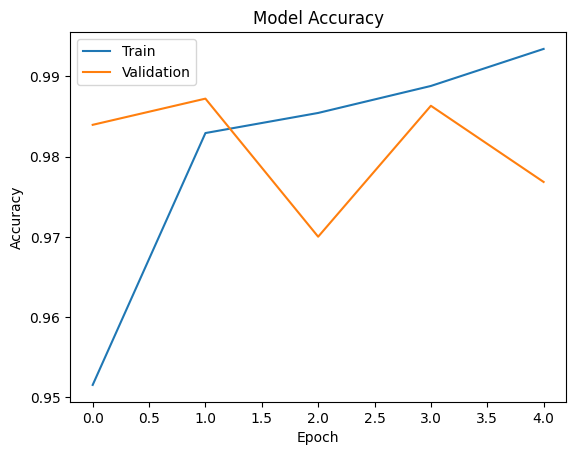

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
